##Unsupervised Learning with Neural Networks
Here, I would like to look at different methods for unsupervised learning in neural networks. I focus on latent variable models where we have observed data $X$ and latent variables $Z$. Our purpose is to learn both a generative, $p_{\theta}(x|z)$, and a recognition model, $q_{\phi}(z|x)$ from the data. A good generative model will assign high probability to our observed data $X$. Therefore, we want to maximize $\log p_{\theta}(X)$ which can be written as  
$$
\log p_{\theta}(X) = \sum_{z} q_{\phi}(z|x) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} + \sum_z q_{\phi}(z|x) \log \frac{q_{\phi}(z|x)}{p_{\theta}(z|x)} \\
= \mathcal{L}(\theta, \phi) + \text{KL}(q_{\phi}(z|x) || p_{\theta}(z|x))
$$

Since $\text{KL}(.||.)$ is always nonnegative, $\mathcal{L}(\theta, \phi)$ is a lower bound on log likelihood, i.e., $\mathcal{L}(\theta, \phi) \leq p_{\theta}(X)$. Therefore, we can maximize log likelihood by maximizing $\mathcal{L}(\theta, \phi)$ with respect to $\theta$ and $\phi$. Note that we can write $\mathcal{L}(\theta, \phi)$ as follows using $p_{\theta}(x,z) = p_{\theta}(x|z)p_{\theta}(z)$
$$
\mathcal{L}(\theta, \phi) = \sum_{z} q_{\phi}(z|x) \log \frac{p_{\theta}(x|z)}{q_{\phi}(z|x)} + \sum_{z} q_{\phi}(z|x) \log \frac{p_{\theta}(z)}{q_{\phi}(z|x)}
$$

This decomposition helps us see what maximizing $\mathcal{L}$ does. We see that the first term tries to bring the recognition and generative models closer to each other. While prior $p_{\theta}(z)$ acts as a regularizer for $q_{\phi}(z|x)$. (In the examples below, to keep things simple, we assume $p_{\theta}(z)$ is uniform.)

Let us calculate the derivatives of $\mathcal{L}$.
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \theta} = \sum_{z} q_{\phi}(z|x) \nabla_{\theta} \log p_{\theta}(x,z) \\
= \mathbb{E}_{q}[\nabla_{\theta} \log p_{\theta}(x,z)]
$$
which can be approximated with samples from $q_{\phi}(z|x)$
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \theta} \approx \frac{1}{L} \sum_{z_l \sim q} \nabla_{\theta} \log p_{\theta}(x,z_l)
\tag 1
$$
Derivative with respect to $\phi$ is a bit more involved
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \phi} = \sum_{z} \nabla_{\phi} q_{\phi}(z|x) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} + q_{\phi}(z|x) \nabla_{\phi} \log \frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \\
= \sum_{z} \nabla_{\phi} q_{\phi}(z|x) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} - \nabla_{\phi} q_{\phi}(z|x) \\
= \sum_{z} \nabla_{\phi} q_{\phi}(z|x) [\log p_{\theta}(x,z) - \log q_{\phi}(z|x) - 1] \\
$$
where we use $\sum_z \nabla q = \nabla \sum_z q = \nabla 1 = 0$ to get
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \phi} = \sum_{z} \nabla_{\phi} q_{\phi}(z|x) [\log p_{\theta}(x,z) - \log q_{\phi}(z|x)] \\
$$
We can turn this into an expectation over $q_{\phi}(z|x)$ by using $\nabla_{\phi} q_{\phi}(z|x) = q_{\phi}(z|x) \nabla_{\phi} \log q_{\phi}(z|x)$ (Williams, 1992; Mnih and Gregor, 2014)
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \phi} = \sum_{z} q_{\phi}(z|x) \nabla_{\phi} \log q_{\phi}(z|x) [\log p_{\theta}(x,z) - \log q_{\phi}(z|x)] \\
= \mathbb{E}_q [\nabla_{\phi} \log q_{\phi}(z|x) [\log p_{\theta}(x,z) - \log q_{\phi}(z|x)]
$$
Again, this can be approximated with samples from $q_{\phi}(z|x)$
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \phi} \approx \frac{1}{L} \sum_{z_l \sim q} [\nabla_{\phi} \log q_{\phi}(z_l|x) [\log p_{\theta}(x,z_l) - \log q_{\phi}(z_l|x)]
\tag 2
$$
However, the above estimate is usually too high variance to be useful in practice. See Mnih and Gregor (2014) for various simple ways to reduce the variance of this estimate. For our simple example below, we will be able to use the above estimate directly. However, as we will see, this estimate will have high variance. 

###Sampling with Neural Networks
We would like to model both $p(x|z)$ and $q(z|x)$ with neural networks. We need to be able to sample from these distributions and calculate probabilities. How can we represent a probability distribution with function approximators such as neural networks? There seems to be two ways to do it. We can assume a functional form for the distribution and let the neural network output the parameters of this distribution. Or we can include stochastic units in the network and let the network directly produce samples from the distribution. However, if we adopt the latter approach, it becomes difficult to calculate probability of a produced sample. Because we have no analytical expression for the probability of a sample (in contrast to the first approach where we assume a functional form), it is unclear how we can calculate for example $\nabla_{\phi} \log q_{\phi}$. Therefore, we adopt the first approach here and let the network outputs represent the parameters of the distribution.

Specifically, we model $p_{\theta}(x|z)$ and $q_{\phi}(z|x)$ with neural networks and assume $x \in \mathbb{R}^D$ and $z \in \mathbb{R}^K$. Networks output the means of the Gaussian distributions from which the outputs are sampled (one can easily extend this to output variances of the distributions as well). Using a simple one layer network,
$$
\mu_z = W_{\phi}x + b_{\phi} \\
z \sim N(\mu_z, \mathbf{I})
$$
and
$$
\mu_x = W_{\theta}z + b_{\theta} \\
x \sim N(\mu_x, \mathbf{I})
$$
We also assume $p_{\theta}(z) \propto 1$ for the sake of simplicity. With the above expressions, it is straightforward to calculate the derivatives of $\mathcal{L}(\theta, \phi)$. 

Let us first generate some data to test our model. We are going to sample 400 points with each 100 drawn from a 4D Gaussian with a different mean. The data points are well separated in 4D space making this a rather simple problem.

In [62]:
# generate data
import numpy as np
import scipy.stats as stat

np.random.seed(123)
m1 = [2., 2., 2., 2.]
m2 = [-2., -2., -2., -2.]
m3 = [-2., -2., 2., 2.]
m4 = [2., 2., -2., -2.]
x1 = stat.multivariate_normal.rvs(m1, size=150)
x2 = stat.multivariate_normal.rvs(m2, size=150)
x3 = stat.multivariate_normal.rvs(m3, size=150)
x4 = stat.multivariate_normal.rvs(m4, size=150)
tx = np.vstack([x1[0:100], x2[0:100], x3[0:100], x4[0:100]])
vx = np.vstack([x1[100:], x2[100:], x3[100:], x4[100:]])
ty = np.zeros(400, dtype=np.int8)
vy = np.zeros(200, dtype=np.int8)
ty[100:200] = 1
vy[50:100] = 1
ty[200:300] = 2
vy[100:150] = 2
ty[300:400] = 3
vy[150:200] = 3

# shuffle
rperm = np.random.permutation(400)
tx = tx[rperm]
ty = ty[rperm]

# randomly initialize parameters (we want all runs to start from the same initial parameters)
w_rec_init = np.random.randn(4, 2).T
b_rec_init = np.random.randn(2)
w_gen_init = np.random.randn(2, 4).T
b_gen_init = np.random.randn(4)

###Method 1: Gradient ascent on variational lower-bound
Now we use gradient ascent to learn the parameters $\theta$ and $\phi$. We use equations 1 and 2 to estimate gradients.

In [63]:
def calc_dl_dgen(xi, w_gen, b_gen, w_rec, b_rec, L=10):
    """Calculate derivative of L with respect to generative parameters
    Parameters:
        xi (ndarray): Training sample
        w_gen: Generative weights
        b_gen: Generative biases
        w_rec: Recognition weights
        b_rec: Recognition biases
        L: Number of samples used to estimate derivatives
    Returns:
        ndarray: Derivative of L wrt to generative weight matrix
        ndarray: Derivative of L wrt to generative biases
    """
    # run recognition network
    mu_zi = np.dot(w_rec, xi) + b_rec
    dl_dw_gen = 0.0
    dl_db_gen = 0.0
    for l in range(L):
        # latent sample
        zi = mu_zi + np.random.randn(*mu_zi.shape)
        # generate x from latent sample
        mu_xi = np.dot(w_gen, zi) + b_gen
        # calculate derivatives
        dl_dw_gen += np.outer((xi - mu_xi), zi)
        dl_db_gen += (xi - mu_xi)
    dl_dw_gen /= L
    dl_db_gen /= L
    return dl_dw_gen, dl_db_gen

def calc_dl_drec(xi, w_gen, b_gen, w_rec, b_rec, L=10):
    """Calculate derivative of L with respect to recognition parameters
    Parameters:
        xi (ndarray): Training sample
        w_gen: Generative weights
        b_gen: Generative biases
        w_rec: Recognition weights
        b_rec: Recognition biases
        L: Number of samples used to estimate derivatives
    Returns:
        ndarray: Derivative of L wrt to recognition weight matrix
        ndarray: Derivative of L wrt to recognition biases
    """
    # run recognition network
    mu_zi = np.dot(w_rec, xi) + b_rec
    dl_dw_rec = 0.0
    dl_db_rec = 0.0
    for l in range(L):
        # latent sample
        zi = mu_zi + np.random.randn(*mu_zi.shape)
        # run generation network
        mu_xi = np.dot(w_gen, zi) + b_gen
        # log p_{\theta}(x,z_l) - log q_{\phi}(z_l|x)
        d = np.sum(np.square(zi - mu_zi)) - np.sum(np.square(xi - mu_xi))
        dl_dw_rec += d*np.outer((zi - mu_zi), xi)
        dl_db_rec += d*(zi - mu_zi)
    dl_dw_rec /= L
    dl_db_rec /= L
    return dl_dw_rec, dl_db_rec

def calc_log_ll(x, w_gen, b_gen, w_rec, b_rec):
    log_ll = 0.0
    for i in range(x.shape[0]):
        xi = x[i]
        zp = np.dot(w_rec, xi) + b_rec
        xp = np.dot(w_gen, zp) + b_gen
        log_ll += -np.sum(np.square(xp - xi))
    return log_ll / x.shape[0]
    

In [66]:
# learn parameters using gradient ascent
w_gen_ga = w_gen_init.copy()  
b_gen_ga = b_gen_init.copy()  
w_rec_ga = w_rec_init.copy()  
b_rec_ga = b_rec_init.copy()  

np.random.seed(456)

epoch_count = 50
lr_gen = 1e-3
lr_rec = lr_gen * 1e-1

log_ll_ga = np.zeros(epoch_count+1)
log_ll_ga[0] = calc_log_ll(vx, w_gen_ga, b_gen_ga, w_rec_ga, b_rec_ga)
print "Initial val log ll: {0:f}".format(log_ll_ga[0])

dwrec_magnitude = np.zeros(tx.shape[0])
for e in range(epoch_count):
    for i in range(tx.shape[0]):
        xi = tx[i]
        dwgen, dbgen = calc_dl_dgen(xi, w_gen_ga, b_gen_ga, w_rec_ga, b_rec_ga, 1)
        w_gen_ga += lr_gen * dwgen
        b_gen_ga += lr_gen * dbgen
        dwrec, dbrec = calc_dl_drec(xi, w_gen_ga, b_gen_ga, w_rec_ga, b_rec_ga, 1)
        w_rec_ga += lr_rec * dwrec
        b_rec_ga += lr_rec * dbrec  
        
        dwrec_magnitude[i] = np.sum(np.square(dwrec))

    log_ll_ga[e+1] = calc_log_ll(vx, w_gen_ga, b_gen_ga, w_rec_ga, b_rec_ga)
    
print "Final val log ll: {0:f}, grad w_rec magnitude in last epoch: {1:f}+-{2:f}".format(log_ll_ga[-1], 
                                                                              np.mean(dwrec_magnitude), 
                                                                              np.std(dwrec_magnitude))


Initial val log ll: -220.898230
Final val log ll: -2.173968, grad w_rec magnitude in last epoch: 351.708501+-1321.195805


In [67]:
log_ll_ga

array([-220.8982299 ,  -11.27735559,   -5.62217486,   -3.996393  ,
         -3.40335132,   -3.02245425,   -2.89599384,   -2.77379335,
         -2.69821009,   -2.73780261,   -2.59322117,   -2.57673695,
         -2.56519878,   -2.56729679,   -2.55311047,   -2.50951205,
         -2.49480074,   -2.44952333,   -2.46921359,   -2.44876269,
         -2.39499181,   -2.41727208,   -2.41195782,   -2.42182138,
         -2.38807787,   -2.35702998,   -2.34320254,   -2.31761296,
         -2.39270913,   -2.3115571 ,   -2.31415359,   -2.30751383,
         -2.3011542 ,   -2.31396751,   -2.32292599,   -2.29285706,
         -2.29303713,   -2.29706077,   -2.2361098 ,   -2.21850509,
         -2.26719972,   -2.24319406,   -2.23679789,   -2.22574751,
         -2.20679805,   -2.25623079,   -2.18015701,   -2.20020025,
         -2.19580425,   -2.23749944,   -2.17396783])

Note the high variance of the gradient with respect to recognition weights.

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


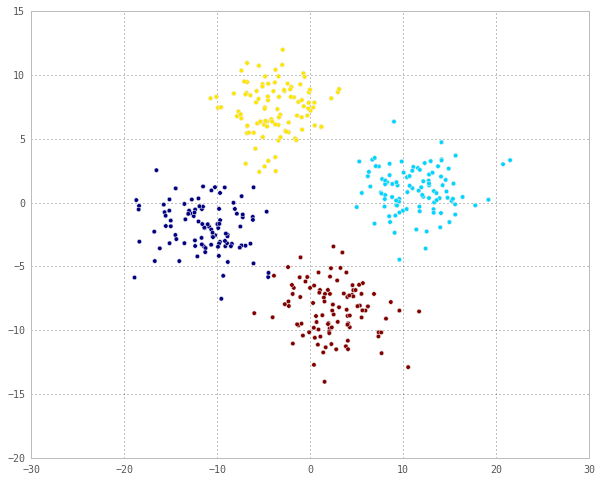

In [60]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)

def plot_z(x, y, w_rec, b_rec):
    z = np.zeros((x.shape[0], 2))
    for i in range(x.shape[0]):
        xi = x[i]
        zi = np.dot(w_rec, xi) + b_rec
        z[i] = zi
    plt.scatter(z[:,0], z[:,1], c=y)
  
# plot the 2D latent space
plot_z(tx, ty, w_rec_ga, b_rec_ga)

###Method 2: Variational autoencoder, i.e., reparameterization trick
One way to calculate low variance estimates of the gradient with respect to recognition parameters is the reparameterization trick (Kingma and Welling, 2014). This trick allows us to calculate the derivative without needing to rewrite $\nabla_{\phi} q_{\phi}(z|x)$ as $q_{\phi}(z|x) \nabla_{\phi} \log q_{\phi}(z|x)$. Without the derivative of $\log q$, we get an estimate with much lower variance. This trick relies on being able to separate the stochastic component in sampling from a distribution. For example, in our case, $z$ are sampled from a normal distribution with mean given by the recognition model.
$$
z \sim N(\mu_z, \mathbf{I}) \\
$$
where $\mu_z$ is some function of $x$, i.e., $\mu_z = h_{\phi}(x)$. If we rewrite $z$ as
$$
z = h_{\phi}(x) + \epsilon \\
\epsilon ~ N(0, \mathbf{I})
$$
we can rewrite the derivative of $\mathcal{L}$ with respect to $\phi$ as
$$
\nabla_{\phi} \mathcal{L}(\theta, \phi) = \nabla_{\phi} \mathbb{E}_q[\log p_{\theta}(x,z) - \log q_{\phi}(z|x)] \\
= \nabla_{\phi} \mathbb{E}_{\epsilon \sim N(0, \mathbf{I})}[\log p_{\theta}(x,h_{\phi}(x) + \epsilon) - \log q_{\phi}(h_{\phi}(x) + \epsilon|x)] \\
= \mathbb{E}_{\epsilon \sim N(0, \mathbf{I})}[\nabla_{\phi} \log p_{\theta}(x,h_{\phi}(x) + \epsilon) - \nabla_{\phi}  \log q_{\phi}(h_{\phi}(x) + \epsilon|x)] \\
$$
where the second term inside the expectation is zero because it is independent of $\phi$ (mean of $q$ is $h_{\phi}(x)$ which cancels the other $h_{\phi}(x)$). Hence,
$$
\nabla_{\phi} \mathcal{L}(\theta, \phi) = \mathbb{E}_{\epsilon \sim N(0, \mathbf{I})}[\nabla_{\phi} \log p_{\theta}(x,h_{\phi}(x) + \epsilon)] \tag 3
$$

Below, we use the above expression to calculate an estimate of the gradient with respect to recognition parameters. As we will see, this estimate has much lower variance. (We still use eqn. 1 to calculate the gradient with respect to $\theta$).

In [20]:
def calc_dl_drec_reparameterized(xi, w_gen, b_gen, w_rec, b_rec, L=10):
    """Calculate derivative of L with respect to recognition parameters using the reparameterization trick
    Parameters:
        xi (ndarray): Training sample
        w_gen: Generative weights
        b_gen: Generative biases
        w_rec: Recognition weights
        b_rec: Recognition biases
        L: Number of samples used to estimate derivatives
    Returns:
        ndarray: Derivative of L wrt to recognition weight matrix
        ndarray: Derivative of L wrt to recognition biases
    """
    # run recognition network
    mu_zi = np.dot(w_rec, xi) + b_rec
    dl_dw_rec = 0.0
    dl_db_rec = 0.0
    for l in range(L):
        # latent sample
        zi = stat.multivariate_normal.rvs(mu_zi)
        # run generation network
        mu_xi = np.dot(w_gen, zi) + b_gen
        # calculate derivatives
        dl_dw_rec += np.dot(w_gen.T, np.outer((xi - mu_xi), xi))
        dl_db_rec += np.dot(w_gen.T, (xi - mu_xi))
    dl_dw_rec /= L
    dl_db_rec /= L
    return dl_dw_rec, dl_db_rec


In [46]:
w_gen_rt = w_gen_init.copy()  
b_gen_rt = b_gen_init.copy()  
w_rec_rt = w_rec_init.copy()  
b_rec_rt = b_rec_init.copy()  

np.random.seed(456)

epoch_count = 100
lr_gen = 1e-3
lr_rec = lr_gen * 1e-1

log_ll_rt = np.zeros(epoch_count+1)
log_ll_rt[0] = calc_log_ll(x, w_gen_rt, b_gen_rt, w_rec_rt, b_rec_rt)
print "Initial log ll: {0:f}".format(log_ll_rt[0])

dwrec_magnitude = np.zeros(x.shape[0])
for e in range(epoch_count):
    for i in range(x.shape[0]):
        xi = x[i]
        dwgen, dbgen = calc_dl_dgen(xi, w_gen_rt, b_gen_rt, w_rec_rt, b_rec_rt, 1)
        w_gen_rt += lr_gen * dwgen
        b_gen_rt += lr_gen * dbgen
        dwrec, dbrec = calc_dl_drec_reparameterized(xi, w_gen_rt, b_gen_rt, w_rec_rt, b_rec_rt, 1)
        w_rec_rt += lr_rec * dwrec
        b_rec_rt += lr_rec * dbrec    
        
        dwrec_magnitude[i] = np.sum(np.square(dwrec))

    log_ll_rt[e+1] = calc_log_ll(x, w_gen_rt, b_gen_rt, w_rec_rt, b_rec_rt)

print "Final log ll: {0:f}, grad w_rec magnitude in last epoch: {1:f}+-{2:f}".format(log_ll_rt[-1], 
                                                                              np.mean(dwrec_magnitude), 
                                                                              np.std(dwrec_magnitude))


Initial log ll: -69611.968257
Final log ll: -844.092357, grad w_rec magnitude in last epoch: 1.817730+-2.189170


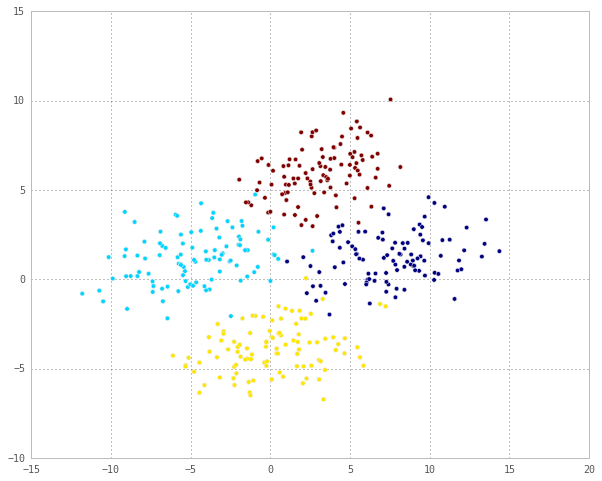

In [45]:
# plot the 2D latent space
plot_z(x, y, w_rec_rt, b_rec_rt)

###Method 3: Wake-sleep Algorithm
Probably the earliest method for training unsupervised learning models like ours is the wake-sleep algorithm by Hinton et al. (1995). This is a heuristic algorithm, and it does not optimize a well-defined bound like the variational lower bound. The algorithm consists of two steps
1. **Wake step:** Freeze the recognition weights $\phi$. Get sample $z$ for data point $x$ and generate $\hat{x}$ from the generative model $p_{\theta}(x|z)$. Update $\theta$ such that $\hat{x}$ is close to $x$. In other words, we want the generative model to generate the $x$ we put in.
2. **Sleep step:** Freeze the generative weights $\theta$. Sample $z$ randomly and generate $x$ from the generative model $p_{\theta}(x|z)$. Run the recognition model $q_{\phi}(z|x)$ to get $\hat{z}$. Update $\phi$ such that $\hat{z}$ is close to $z$. In other words, we want the recognition model to be able to recognize a fantasy $x$.
More formally, in the wake step we are maximizing the following objective
$$
\mathbb{E}_{q}[\log p_{\theta}(x|z)] \approx \frac{1}{L} \sum_{z_l \sim q_{\phi}} \log p_{\theta}(x|z_l)
$$
Note that this is the same objective with the one we get from the variational lower bound (the derivative with respect to $\theta$ is the same with equation 1). Wake step is the gradient ascent step with respect to $\theta$. In the sleep step, we are maximizing the following objective
$$
\mathbb{E}_{p}[\log q_{\phi}(z|x)] \approx \frac{1}{L} \sum_{x_l \sim p_{\theta}} \log q_{\phi}(x_l|z)
$$
In contrast to the wake step, the sleep step does not correspond to gradient ascent with respect to $\phi$. This is why we say that wake-sleep algorithm does not optimize a well-defined objective. Nevertheless, this algorithm works in practice. However, we would expect it to work worse than the methods we looked at above. 

In [23]:
def wake_sleep(xi, w_gen, b_gen, w_rec, b_rec, L=10):
    """Apply one step of wake-sleep algorithm and get updates for generative and recognition parameters
    Parameters:
        xi (ndarray): Training sample
        w_gen: Generative weights
        b_gen: Generative biases
        w_rec: Recognition weights
        b_rec: Recognition biases
        L: Number of samples used to estimate derivatives
    Returns:
        ndarray: Update for generative weight matrix
        ndarray: Update for generative biases
        ndarray: Update for recognition weight matrix
        ndarray: Update for recognition biases
    """
    # run recognition network
    mu_zi = np.dot(w_rec, xi) + b_rec
    dl_dw_gen = 0.0
    dl_db_gen = 0.0
    dl_dw_rec = 0.0
    dl_db_rec = 0.0
    for l in range(L):
        # latent sample
        zi = stat.multivariate_normal.rvs(mu_zi)
        # generate x from latent sample
        mu_xi = np.dot(w_gen, zi) + b_gen
        xi_pred = stat.multivariate_normal.rvs(mu_xi)
        # run recognition on predicted x
        mu_zi_pred = np.dot(w_rec, xi_pred) + b_rec
        zi_pred = stat.multivariate_normal.rvs(mu_zi)
        # calculate derivatives
        dl_dw_gen += np.outer((xi - xi_pred), zi)
        dl_db_gen += (xi - xi_pred)
        dl_dw_rec += np.outer((zi - zi_pred), xi_pred)
        dl_db_rec += (zi - zi_pred)
    dl_dw_gen /= L
    dl_db_gen /= L
    dl_dw_rec /= L
    dl_db_rec /= L
    return dl_dw_gen, dl_db_gen, dl_dw_rec, dl_db_rec

In [36]:
w_gen_ws = w_gen_init.copy()  
b_gen_ws = b_gen_init.copy()  
w_rec_ws = w_rec_init.copy()  
b_rec_ws = b_rec_init.copy()  

np.random.seed(456)

epoch_count = 100
lr_gen = 1e-4
lr_rec = lr_gen * 1e-1

log_ll_ws = np.zeros(epoch_count+1)
log_ll_ws[0] = calc_log_ll(x, w_gen_ws, b_gen_ws, w_rec_ws, b_rec_ws)
print "Initial log ll: {0:f}".format(log_ll_ws[0])

dwrec_magnitude = np.zeros(x.shape[0])
for e in range(epoch_count):
    for i in range(x.shape[0]):
        xi = x[i]
        dwgen, dbgen, dwrec, dbrec = wake_sleep(xi, w_gen_ws, b_gen_ws, w_rec_ws, b_rec_ws, 1)
        w_gen_ws += lr_gen * dwgen
        b_gen_ws += lr_gen * dbgen
        w_rec_ws += lr_rec * dwrec
        b_rec_ws += lr_rec * dbrec    
        
        dwrec_magnitude[i] = np.sum(np.square(dwrec))

    log_ll_ws[e+1] = calc_log_ll(x, w_gen_ws, b_gen_ws, w_rec_ws, b_rec_ws)

print "Final log ll: {0:f}, grad w_rec magnitude in last epoch: {1:f}+-{2:f}".format(log_ll_ws[-1], 
                                                                              np.mean(dwrec_magnitude), 
                                                                              np.std(dwrec_magnitude))


Initial log ll: -69611.968257
Final log ll: -1697.332688, grad w_rec magnitude in last epoch: 80.323872+-131.742327


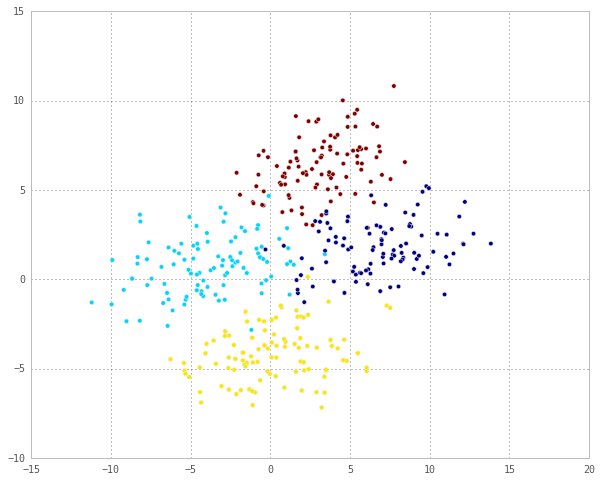

In [25]:
plot_z(x, y, w_rec_ws, b_rec_ws)

###Method 4: Classical autoencoder
How is the model we looked at so far different from a classical [autoencoder](https://en.wikipedia.org/wiki/Autoencoder)? Our latent variable model is a probabilistic model. We are learning two probability distributions: generative distribution $p$ and recognition distribution $q$. However, a classical autoencoder is not a probabilistic model; the purpose is simply to learn a compressed representation of the input data. However, in terms of architecture, the classical autoencoder is almost identical to the model we looked at so far. In fact, the only difference is the sampling step where the latent variable $z$ is sampled from some mean $\mu_z$ that is produced by the recognition model. In a classical autoencoder, $\mu_z$ would be used directly as our latent representation $z$. In addition, for our model, we optimized the variational lower bound. In a classical autoencoder, on the other hand, we optimize reconstruction error. Hence, it seems unclear if and how the two models are related.

Let us look at the gradient expressions for classical autoencoder. Assume we have two functions: generation function $g_{\theta}(x)$ and recognition function $h_{\phi}(x)$. Then the purpose is to learn $g$ and $h$ that minimizes the following objective
$$
R(\theta, \phi) = \sum_n ||x_n - g_{\theta}(h_{\phi}(x_n))||_2^2
$$
Focusing on a single data point $x$, the derivatives with respect to $\theta$ and $\phi$ are as follows:
$$
\frac{\partial R(\theta, \phi)}{\partial \theta} = -(x - g_{\theta}(h_{\phi}(x)))\nabla_{\theta} g_{\theta}(h_{\phi}(x)) \\
\frac{\partial R(\theta, \phi)}{\partial \phi} = -(x - g_{\theta}(h_{\phi}(x))) g_{\theta}'(h_{\phi}(x)) \nabla_{\phi} h_{\phi}(x)
$$

Now let us look at the derivatives of the variational lower bound again. Starting from equation 1 and making use of the reparameterization trick, we can write
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \theta} \approx \frac{1}{L} \sum_{z_l \sim q} \nabla_{\theta} \log p_{\theta}(x,z_l) \\
= \frac{1}{L} \sum_{\epsilon \sim N(0,\mathbf{I})} \nabla_{\theta} \log p_{\theta}(x,h_{\phi}(x) + \epsilon)) \\
= -\frac{1}{L} \sum_{\epsilon \sim N(0,1)} \nabla_{\theta} ||x - g_{\theta}(h_{\phi}(x) + \epsilon))||_2^2 \\
= \frac{1}{L} \sum_{\epsilon \sim N(0,1)} (x - g_{\theta}(h_{\phi}(x) + \epsilon))\nabla_{\theta} g_{\theta}(h_{\phi}(x) + \epsilon)
$$
Here we used $g_{\theta}(z)$ to denote the function calculates $\mu_x$ from $z$. Note that if we ignore sampling $z$ and use $\mu_z$ directly, i.e., set $\epsilon=0$, the above expression is the same with the derivative of $R$ with respect to $\theta$ (ignoring sign difference because we are maximizing instead of minimizing here). 

Similarly, starting from equation 3, we can write the derivative of the variational lower bound with respect to $\phi$ as follows
$$
\nabla_{\phi} \mathcal{L}(\theta, \phi) = \mathbb{E}_{\epsilon \sim N(0, \mathbf{I})}[\nabla_{\phi} \log p_{\theta}(x,h_{\phi}(x) + \epsilon)] \\
= \frac{1}{L} \sum_{\epsilon \sim N(0,1)} \nabla_{\phi} \log p_{\theta}(x,h_{\phi}(x) + \epsilon) \\
= -\frac{1}{L} \sum_{\epsilon \sim N(0,1)} \nabla_{\phi} ||x - g_{\theta}(h_{\phi}(x) + \epsilon))||_2^2 \\
= \frac{1}{L} \sum_{\epsilon \sim N(0,1)} (x - g_{\theta}(h_{\phi}(x) + \epsilon)))g_{\theta}'(h_{\phi}(x) + \epsilon) \nabla_{\phi} h_{\phi}(x) \\
$$
Again if we set $\epsilon=0$, this expression is the same with the derivative of $R$ with respect to $\phi$. Therefore, classical autoencoder is equivalent to a variational autoencoder where we ignore stochasticity in $z$, i.e., assume the recognition model is deterministic. However, note that we were able to derive this equivalency thanks to the following assumptions:
* Generative model $p_{\theta}(x|z)$ is Gaussian with variance independent of $z$. This assumption made minimizing reconstruction error equivalent  to maximizing probability. 
* Recognition model $q_{\phi}(z|x)$ is Gaussian with variance independent of $x$. This made it possible to write $z = h_{\phi}(x) + \epsilon$.

Now let us look at how well a classical autoencoder does on our toy problem. This should give us an idea about how much we lose if we ignore stochasticity in $z$. 

In [37]:
def calc_dl_dgen_ae(xi, w_gen, b_gen, w_rec, b_rec):
    """Calculate derivative of R (reconstruction error for classical autoencoder) 
    with respect to generative parameters
    Parameters:
        xi (ndarray): Training sample
        w_gen: Generative weights
        b_gen: Generative biases
        w_rec: Recognition weights
        b_rec: Recognition biases
    Returns:
        ndarray: Derivative of R wrt to generative weight matrix
        ndarray: Derivative of R wrt to generative biases
    """
    # run recognition network
    mu_zi = np.dot(w_rec, xi) + b_rec
    # generate x from latent z
    mu_xi = np.dot(w_gen, mu_zi) + b_gen
    # calculate derivatives
    dl_dw_gen = np.outer((mu_xi - xi), mu_zi)
    dl_db_gen = (mu_xi - xi)
    return dl_dw_gen, dl_db_gen

def calc_dl_drec_ae(xi, w_gen, b_gen, w_rec, b_rec):
    """Calculate derivative of R (reconstruction error for classical autoencoder) 
    with respect to recognition parameters
    Parameters:
        xi (ndarray): Training sample
        w_gen: Generative weights
        b_gen: Generative biases
        w_rec: Recognition weights
        b_rec: Recognition biases
    Returns:
        ndarray: Derivative of R wrt to recognition weight matrix
        ndarray: Derivative of R wrt to recognition biases
    """
    # run recognition network
    mu_zi = np.dot(w_rec, xi) + b_rec
    # run generation network
    mu_xi = np.dot(w_gen, mu_zi) + b_gen
    # calculate derivatives
    dl_dw_rec = np.dot(w_gen.T, np.outer((mu_xi - xi), xi))
    dl_db_rec = np.dot(w_gen.T, (mu_xi - xi))
    return dl_dw_rec, dl_db_rec


In [38]:
w_gen_ae = w_gen_init.copy()  
b_gen_ae = b_gen_init.copy()  
w_rec_ae = w_rec_init.copy()  
b_rec_ae = b_rec_init.copy()  

np.random.seed(456)

epoch_count = 100
lr_gen = 1e-3
lr_rec = lr_gen * 1e-1

log_ll_ae = np.zeros(epoch_count+1)
log_ll_ae[0] = calc_log_ll(x, w_gen_ae, b_gen_ae, w_rec_ae, b_rec_ae)
print "Initial log ll: {0:f}".format(log_ll_ae[0])

dwrec_magnitude = np.zeros(x.shape[0])
for e in range(epoch_count):
    for i in range(x.shape[0]):
        xi = x[i]
        dwgen, dbgen = calc_dl_dgen_ae(xi, w_gen_ae, b_gen_ae, w_rec_ae, b_rec_ae)
        w_gen_ae -= lr_gen * dwgen
        b_gen_ae -= lr_gen * dbgen
        dwrec, dbrec = calc_dl_drec_ae(xi, w_gen_ae, b_gen_ae, w_rec_ae, b_rec_ae)
        w_rec_ae -= lr_rec * dwrec
        b_rec_ae -= lr_rec * dbrec    
        
        dwrec_magnitude[i] = np.sum(np.square(dwrec))

    log_ll_ae[e+1] = calc_log_ll(x, w_gen_ae, b_gen_ae, w_rec_ae, b_rec_ae)
    
print "Final log ll: {0:f}, grad w_rec magnitude in last epoch: {1:f}+-{2:f}".format(log_ll_ae[-1], 
                                                                              np.mean(dwrec_magnitude), 
                                                                              np.std(dwrec_magnitude))


Initial log ll: -69611.968257
Final log ll: -829.748683, grad w_rec magnitude in last epoch: 0.607862+-0.958380


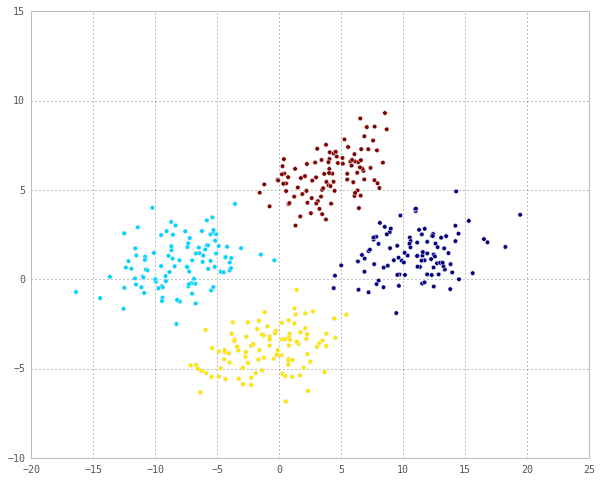

In [39]:
# plot the 2D latent space
plot_z(x, y, w_rec_ae, b_rec_ae)

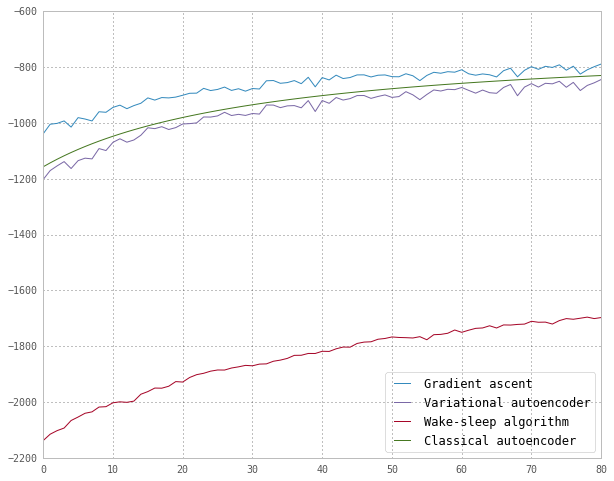

In [40]:
# Let us compare the log likelihoods for each algorithm
plt.plot(range(81), log_ll_ga[20:])
plt.plot(range(81), log_ll_rt[20:])
plt.plot(range(81), log_ll_ws[20:])
plt.plot(range(81), log_ll_ae[20:])
plt.legend(['Gradient ascent', 'Variational autoencoder', 'Wake-sleep algorithm', 'Classical autoencoder'], loc='best')

####To-do
Compare VAE and AE on MNIST.